In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import pandas as pd
import pickle
import cmcrameri.cm as cmc

In [2]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [3]:
def get_ye_stf(ye_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/Ye_et_al_2016/'
    momentrate = []
    time = []

    with open(data_path + str(ye_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))
    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [4]:
def get_usgs_stf(usgs_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/USGS/'
    momentrate = []
    time = []

    with open(data_path + str(usgs_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)

    momentrate = momentrate / 10**7 # convert to Nm from dyne cm
    return momentrate, time

In [5]:
def get_sigloch_stf(sigloch_name):
    data_path = '/home/siglochnas1/shared/AmplitudeProjects/pdata_processed/psdata_events/'
    momentrate = []
    time = []

    file_path = data_path + str(sigloch_name) + '/outfiles/ampinv.stf.xy'

    with open(file_path, 'r') as file:
        content = file.read()
        content = content.split('\n')
        greater_than_count = content.count('>')
        if greater_than_count > 0:
            time = [list(np.arange(0, 25.6, 0.1))]
            momentrate = [[]]
            for i in range(greater_than_count-1):
                time.append(list(np.arange(0, 25.6, 0.1)))
                momentrate.append([])


        stf_count = 0
        for c in content:
            if c not in ['<', '>', '']:
                split = c.split()
                #time[stf_count].append(float(split[0]))
                momentrate[stf_count].append(10**float(split[1]))
            else:
                stf_count += 1

    # time = np.arange(0, 25.6, 0.1)
    # time = np.array(time)
    return momentrate, time

In [6]:
def get_isc_stf(isc_name):
    isc_save_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/isc/'
    with open(f'{isc_save_path}{isc_name}/{isc_name}.txt', 'rb') as f:
        stf_list = pickle.load(f)
    with open(f'{isc_save_path}{isc_name}/{isc_name}_norm_info.txt', 'rb') as f:
        norm_dict = pickle.load(f)

    time = np.arange(0, 25.6, 0.1)
    momentrate = np.array(stf_list)*norm_dict['mo_norm']*10**8,
    #print(momentrate)
    return momentrate[0], time

In [7]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')

In [8]:
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [9]:
def find_end_stf(momentrate, time, dataset = ''):
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]

    if dataset == 'sigloch':
        start = np.where(momentrate > 0.05 * max(momentrate))[0][0]
    else:
        start = min(not_zero)
    #print(less_than_10)
    total_moment = scipy.integrate.simpson(momentrate[start:end],
                                        dx = time[1]-time[0])
    #print(less_than_10)
    for i in less_than_10:
        if i <= start:
            continue
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[start:i],
                                        dx = time[1]-time[0])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
            break
    return detected_end_time, detected_end, time[start], start
    #return time[end], end

In [10]:
to_ignore = ['20051203_1610_1', '20071226_2204_2', '20030122_0206_1', '20090929_1748_0', '20120421_0125_1', '20110311_2011_2']

columns_to_save = ['event', 'dataset', 'mag', 'interp_momentrate']
df_interp = pd.DataFrame(columns = columns_to_save)
max_len = 0
for i, row in combined.iterrows():
	# if i < 360:
	# 	continue

	#fig, axs = plt.subplots(2, 1, figsize=(10, 10))


	for dataset, get_stf in zip(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc'], [get_scardec_stf, get_scardec_stf, get_ye_stf, get_usgs_stf, get_sigloch_stf, get_isc_stf]):

		if dataset == 'scardec_moy' or dataset == 'scardec_opt':
			name = row[dataset[:-4]]
		else:
			name = row[dataset]

		if name == '0' or name == 0:
			continue

		if dataset == 'scardec_moy':
			momentrate, time = get_stf(name, 'fctmoy')
		elif dataset == 'scardec_opt':
			momentrate, time = get_stf(name, 'fctopt')
		else:
			momentrate, time = get_stf(name)

		if dataset != 'sigloch':
			momentrate_list = [momentrate]
			time_list = [time]
		else:
			momentrate_list = momentrate
			time_list = time

		count = 0
		for momentrate, time in zip(momentrate_list, time_list):
			if time[0] == time[1]:
				time = time[1:]

			if dataset != 'sigloch':
				save_key = row.event
				dataset_name = dataset
			else:
				dataset_name = dataset + '_' + str(count)
				save_key = row.event + '_' + str(count)

			if save_key in to_ignore:
				continue
			#print(time[0:10])
			
			momentrate = np.array(momentrate)

			time = np.array(time)
			detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time, dataset)
			time = time[detected_start:detected_end] # shift to start STF at zero
			time = time - time[0]
			momentrate = momentrate[detected_start:detected_end]
			max_len = max(max_len, len(momentrate))
			norm_momentrate = momentrate / max(momentrate)
			norm_time = time / max(time)
			#axs[0].plot(norm_time, norm_momentrate)

			interp_momentrate = np.interp(np.linspace(0, 1, 10000), norm_time, norm_momentrate)
			interp_momentrate[interp_momentrate < 0] = 0

			#axs[1].plot(np.linspace(0, 1, 100), interp_momentrate)

			df_interp = pd.concat([df_interp, pd.DataFrame([[row.event, dataset_name, row.mag, interp_momentrate]], columns = columns_to_save)], ignore_index = True)
			count += 1
	#plt.show()
	#plt.close()
	# if i > 361:
	# 	break
	# 	break


In [63]:
average_momentrate = []
max_momentrate = []

for i in range(max_len):
	average_momentrate.append(np.mean(df_interp[df_interp.index == i]['interp_momentrate'].values[0]))
	max_momentrate.append(df_interp[df_interp.index == i]['interp_momentrate'].values[0].max())

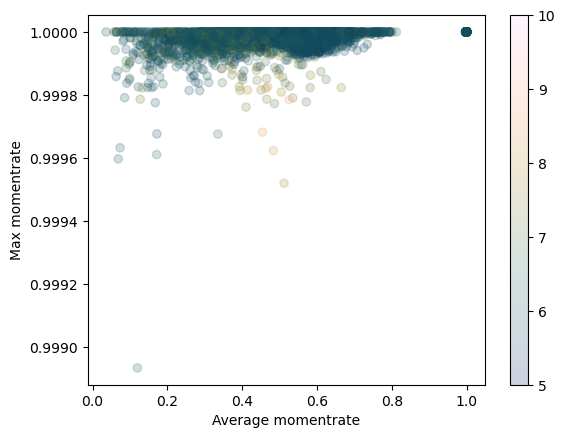

In [62]:
plt.scatter(average_momentrate, max_momentrate, cmap = cmc.batlow, c = df_interp['mag'], alpha = 0.2, vmin = 5, vmax = 10)
plt.ylabel('Max momentrate')
plt.xlabel('Average momentrate')
plt.colorbar()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/peak_mr_vs_average_mr_for_all.png')


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc5/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


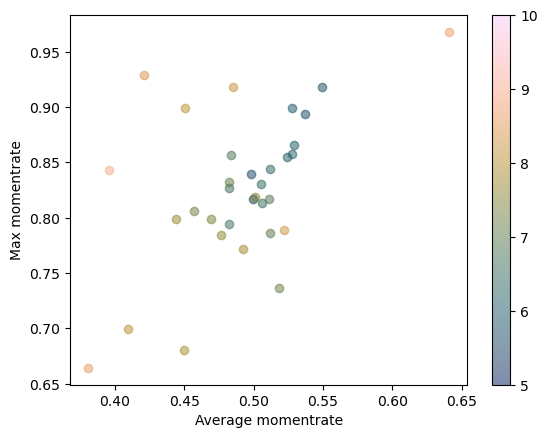

In [60]:
interval = 0.1
boundaries = np.arange(5.5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	subset_median = np.nanmedian(list(subset), axis = 0)

	if type(np.nanmedian(list(subset), axis = 0)) is np.ndarray:
		average_mr = np.median(list(subset_median), axis = 0)
		max_mr = np.max(list(subset_median), axis = 0)
		plt.scatter(average_mr, max_mr, cmap = cmc.batlow, c = b, alpha = 0.5, vmin = 5, vmax = 10)

plt.ylabel('Max momentrate')
plt.xlabel('Average momentrate')
plt.colorbar()

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/peak_mr_vs_average_mr_for_medians.png')



25
56
584
1595
1577
1581
1314
1084
955
691
570
498
354
353
306
238
170
160
92
135
89
73
86
64
41
32
18
14
17
4
0
false
4
5
0
false
0
false
4


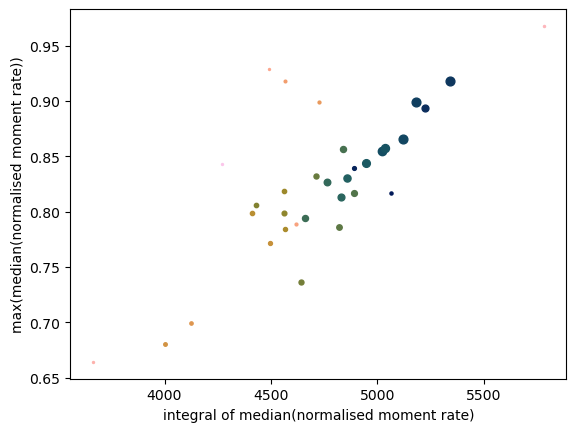

In [59]:
interval = 0.1
boundaries = np.arange(5.5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	print(len(subset))
	if len(subset) < 100:
		marker = ':'
	else:
		marker = '-'

	if type(np.nanmedian(list(subset), axis = 0)) is np.ndarray:
		moment = scipy.integrate.cumtrapz(np.nanmedian(list(subset), axis = 0))[-1]
		#if np.isnan(np.nanmedian(list(subset), axis = 0)) is not True:
		#cumsum = scipy.integrate.cumtrapz(np.nanmedian(list(subset), axis = 0))#, np.linspace(0, 1, 10000))
		plt.scatter(moment, max(np.nanmedian(list(subset), axis = 0)), label = f'{b:.1f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], s = np.sqrt(len(subset)))#, linestyle = marker)
	else:
		print('false')

plt.ylabel('max(median(normalised moment rate))')
plt.xlabel('integral of median(normalised moment rate)')

	#plt.title(f'Events M{b:.1f} --- {b+0.1:.1f}')

#plt.show()
#plt.legend()

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/peak_mr_vs_integral_of_mr.png')
plt.show()

